In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.style.use('max_style.mplstyle')

from numba.experimental import jitclass
import numba as nb
from scipy.interpolate import interp1d

from tqdm import tqdm
from time import time
from spl import spline

%matplotlib inline

ModuleNotFoundError: No module named 'spl'

## Table of contents:
* [Define Verlet and System Base Class](#first-bullet)
    * [load trap geometry](#load-trap-geometry)
* [Test system with "theory" ramps](#Test-system-with-theory-ramps)
    * [rescale excitation energy from eV to n$\hbar\omega$](#rescale)
    * [Plot result](#restheory)
* [Test system with Janines ramps](#janiramps)
    * [Single Transport](#singt)
    * [Plot result](#resjanine)
    * [investigate high excitation regions](#investigate)
* [Introduce a filter compensation](#filtercomp)


# <center>Define Verlet and System Base Class</center><a id="first-bullet"></a>

In [2]:
class verlet():
    def getAcc(self, positions, _):
        """
        simple harmonic oscillator.
        This is for testing purposes. The user should 
        overload this function in order to implement the system
        that should be simulated. 
        (like multiple ions interact with eachother)
        """
        
        return -positions
    
    def integrate(self, endtime, dt):
        """
        calculate the trajectory for N Ions in M Dimensions.
        implemented shortened velocity verlet from:
        https://en.wikipedia.org/wiki/Verlet_integration
        assumes, that acceleration only depends on position.

        Parameters
        ----------
        self.getAcc : function(array) : array
            verlet integrates only, so acceleration function
            needs to implemented by the user!
            see getAcc docstring

        endtime : float
            Seconds on where to end simulation.

        dt : float
            step size between each evaluation step in Seconds.
            With our setup of iontraps less or equal to
            5e-9 is recommended! (redtrap)

        Returns
        -------
        tpoints : np.array
            points of all evaluated timesteps

        ppoints : np.array
            ppoints[:, 0, 0, 0]
                    |  |  |  |
                    |  |  |  > dimension x (or general 1st dim)
                    |  |  > 0 is position, 
                    |  |    1 velocity, 2 acceleration
                    |  > choose ion #0
                    > all timesteps
        """

        n = int(endtime / dt)
        shape = (n,) + self.ions.shape
        tpoints = np.linspace(0, endtime, n)
        ppoints = np.empty(shape, dtype=np.float64)

        ppoints[0] = self.ions

        # iterate through all timepoints, see wiki link in docstring
        for k in range(len(tpoints)-1):
            ppoints[k+1, :, 0] = ppoints[k, :, 0] + ppoints[k, :, 1] * dt + 0.5 * ppoints[k, :, 2] * dt**2
            ppoints[k+1, :, 2] = self.getAcc(ppoints[k+1, :, 0, 0], k+1)
            ppoints[k+1, :, 1] = ppoints[k, :, 1] + 0.5 * (ppoints[k, :, 2] + ppoints[k+1, :, 2]) * dt

        return tpoints, ppoints

In [3]:
spec = [('ions', nb.float64[:, :, :]),
        ('trap', nb.float64[:, :, :]),
        ('splcoeff', nb.float64[:, :, :]),
        ('volt', nb.float64[:, :]),
        ('qdm', nb.float64),]

@jitclass(spec)
class red_system(verlet, spline):
    def __init__(self, trap):
        
        self.splcoeff = np.empty(trap.shape)
        
        for i in range(len(trap)):
            self.splcoeff[i, 0] = self.splrep(trap[i, 0], trap[i, 1])
            self.splcoeff[i, 1] = self.splrep(trap[i, 0], trap[i, 2])
        
        self.trap = trap
        
        q = 1.60217662e-19
        m = 1.66054e-27*39.96259
        self.qdm = q/m
        
    def propagate(self, ramp, endtime, dt):
        n = int(endtime / dt)
        tpoints = np.linspace(0, endtime, n)
        
        self.volt = np.zeros((len(ramp)-1, n))
        for i in range(len(ramp)-1):
            self.volt[i] = np.interp(tpoints, ramp[0], ramp[i+1])
        
        return self.integrate(endtime, dt)
        
        
    def setIons(self, positions):
        """
        set the initial positions of the ions.
        
        Parameters
        ----------
        posistions : np.array
            has size (#numberOfIons, positions).
            For one dim (x, 3, 1), for 3 dim (x, 3, 3)
            with position, velocity, acceleration
        """
        self.ions = positions
    
    def getAcc(self, position, k):
        acc = np.zeros(position.shape)
        
        for i in range(len(self.trap)):
            acc += self.volt[i, k] * self.splev(position, self.trap[i, 0], self.trap[i, 2], self.splcoeff[i, 1])
            
        return acc * self.qdm
    
    def getPot(self, position, k):
        pot = np.zeros(position.shape)
        
        for i in range(len(self.trap)):
            pot += self.volt[i, k] * self.splev(position, self.trap[i, 0], self.trap[i, 1], self.splcoeff[i, 0])
            
        return pot

### load trap geometry <a id="load-trap-geometry"></a>

In [4]:
trap = np.load('redtrap.npy')
trap[:, 0] *= 1e-3
trap[:, 1:] *= 2
trap.shape

(16, 3, 12869)

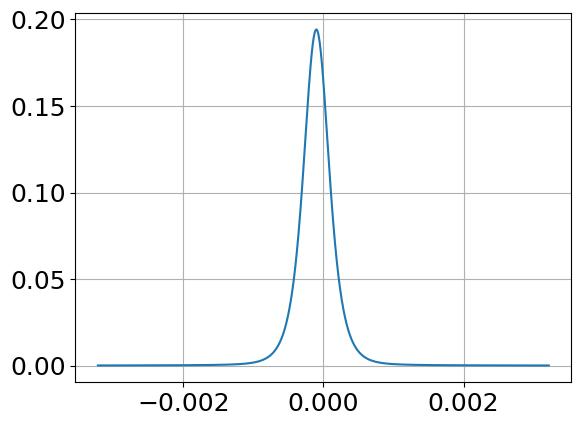

In [5]:
plt.plot(trap[15, 0], trap[15,1])

In [6]:
from scipy.optimize import minimize

array([-0.10475576])

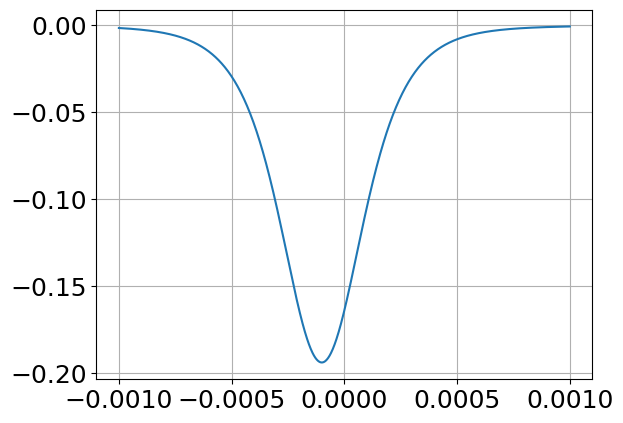

In [8]:
test = red_system(trap)  
test.setIons(np.array([[[-300.0e-6],[0],[0]],], dtype=np.float64))
voltage = np.zeros((16, 1))
voltage[15, 0] = -1
test.volt = voltage
#print(minimize(lambda t: test.getPot(np.array([t]), 0)[0], 300e-6))

x = np.linspace(-1e-3, 1e-3, 1000)
plt.plot(x, test.getPot(x, 0))
test.getPot(np.array([100e-6]), 0)

## <center>Test system with theory ramps</center> <a id="Test-system-with-theory-ramps"></a>

The ramps are taken from Janine's measurement from the 28-11-20, folder 00, <br>
and then scaled up dynamically.<br>
Since we are adding no bertha sampling points here, we don't expect a 180° Phase shift.


In [14]:
result = []
redramp = np.load('redramp.npy')

def run(i, j):
    transport = np.zeros((17, 108), dtype=np.float64)
    transport[[0, 15, 16], :54] = redramp[:, :54]
    transport[0, :54] *= j
    transport[0, 54:] = transport[0, :54] + i + transport[0, 53]
    transport[15, 54:] = transport[16, :54]
    transport[16, 54:] = transport[15, :54]

    test = red_system(trap)  
    test.setIons(np.array([[[-300.0e-6],[0],[0]],], dtype=np.float64))
    t, p = test.propagate(transport, transport[0, -1], 5e-9)
    volt = test.getPot(p[-1, :, 0, 0], -1)
    volt0 = test.getPot(p[0, :, 0, 0], 0)
    
    # masse u in eV
    c = 299792458# m/s
    massunit = 931.49410242e6/c**2 # eV * s^2 / m^2
    mCa40 = 39.962590866 * massunit
    
    # energy in eV
    energy = volt-volt0 + 0.5 * mCa40 * p[-1, 0, 1, 0]**2

    return [i, j, energy[0]]


for i in tqdm(np.linspace(0, 1e-6, 32)):
    for j in np.linspace(1, 1.06, 30):
        result.append(run(i, j))

100%|██████████| 32/32 [01:31<00:00,  2.87s/it]


### Rescale excitation energy from eV to n$\hbar\omega$ <a id="rescale"></a>

In [10]:
hbar = 6.62607015e-34 / 2 / np.pi
omega = 9.83511943e+06
hbar_omega = hbar * omega

# in eV
hbar_omega = hbar_omega / 1.602176634e-19

### Plot result <a id="restheory"></a>

Text(0, 0.5, 'transporttime [us]')

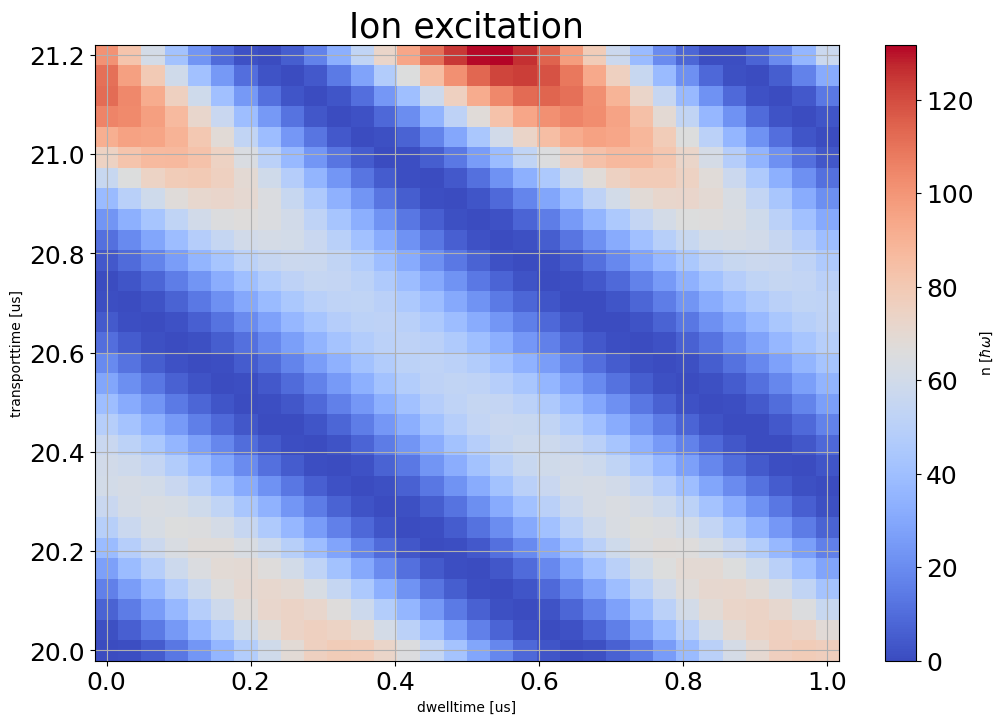

In [15]:
r = np.array(result)
fig, ax = plt.subplots(figsize=(12,8))
pc = ax.pcolormesh(r[:, 0].reshape((-1, 30))*1e6, 
                   r[:, 1].reshape((-1, 30))*20, 
                   r[:, 2].reshape((-1, 30))/hbar_omega, cmap='coolwarm')

cbar = fig.colorbar(pc)
cbar.set_label(r'n [$\hbar\omega$]')
ax.set_title('Ion excitation')
ax.set_xlabel("dwelltime [us]")
ax.set_ylabel("transporttime [us]")

# <center>Introduce a filter compensation</center><a id="filtercomp"></a>